In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import vstack, csr_matrix, coo_matrix
from scipy.sparse.linalg import svds
import sys
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import copy

In [129]:
def load_data(fpath, code="big5hkscs"):
    """
    Read bytes as list of string
    """
    lines = []
    num_errors = 0
    for line in open(fpath, "rb"):
        try:
            lines.append(line.rstrip().decode(code))
        except UnicodeDecodeError as e:
            num_errors += 1
    print('Encountered %d decoding errors.' % num_errors)
    
    return lines

def extract_ngram(s, n, delimiter=' ', get_map=False):
    """
    Extract n grams from string s, using defined single or multiple separator
    """
    size = len(s)
    if get_map: # result stored in set, no class label
        res = set()
    else: # result store in list, with class label
        res = []
    left = 0
    while left<size:
        if s[left] == delimiter:
            left += 1
        else:
            idx = [left] # store indices for n grams
            right = left
            for i in range(1, n): # find n-1 non-separator characters
                right += 1
                while right<size: # find next non-separator characters
                    if s[right]==delimiter:
                        right += 1
                    else:
                        idx.append(right)
                        break;
            if len(idx) == n: # n grams found
                a = int((len(idx)-1)/2) # lower median
                temps = ""
                for x in idx:
                    temps += s[x]
                    
                if get_map:
                    if temps not in res:
                        res.add(temps)
                else:
                    if idx[a]+1 == idx[a+1]: # 4 gram "abcd", no seperator between b and c 
                        res.append([temps, 0])
                    else:
                        res.append([temps, 1])
            left += 1
                
    return res

def parse_all(data_list):
    """
    Concatenate list of strings to one string, separated by double space 
    """
    temp_line = ""
    for line in data_list:
        temp_line += (line + "  ")
    
    return temp_line

def set2dict(s):
    """
    Convert Set object to dict object
    """
    d = {}
    for i, k in enumerate(s):
        d[k] = i
    return d

def encode_word(gram4, grams_map):
    """
    Using [ab, b, bc, c, cd] vector to encode 4-gram abcd. ab, b, bc, c, cd are encoded in a one vector whose
    size is the number of unique 1 and 2 grams in training and testing datasets
    """
    x = []
    y = []
    count = 0
    for g in gram4:
        f, v = g # parse 4 gram and class label
        sgram = np.array([f[0:2], f[1:2], f[1:3], f[2:3], f[2:4]]) # encoding vector
        # Use coordinate format sparse matrix
        row = np.zeros([len(sgram), ])
        col = []
        data = np.ones([len(sgram), ])
        for e in sgram:
            if e not in grams_map: # error handle when not find any element of encoding vector
                raise KeyError("Feature not found.")
            col.append(grams_map[e]) # column number is the position in all 1 and 2 grams
        a = coo_matrix((data, (row, col)), shape=[1, len(grams_map)])
        x.append(a)
        y.append(v)
        
        if count % 10000 ==0:
            print(count)
        count += 1
        
    x = vstack(x)
    y = np.stack(y, axis=0)
    return x, y

def evaluate(clf, x, y):
    y_pred = clf.predict(x)
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y[i]==1:
            tp += 1
        if y_pred[i] == 1 and y[i] == 0:
            fp += 1
        if y_pred[i] == 0 and y[i] == 1:
            fn += 1
        if y_pred[i] == 0 and y[i] == 0:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + fp + tn + fn)
    print("tp, fp, tn, fn: ", tp, fp, tn, fn)
    
    return precision, recall, acc

def get_unique_bchar(s, code="big5hkscs"):
    res = {}
    bchar = s.encode(code)
    for c in bchar:
        if c in res:
            res[c] += 1
        else:
            res[c] = 1
    return res

def check_inmap(s, char_map, code="big5hkscs"):
    count = 0
    bchar = s.encode(code)
    for c in bchar:
        if c not in char_map:
            count += 1
    return count

## Load data as list

In [3]:
code = "big5hkscs"
data_te_str = load_data("test.txt", code=code)
data_tr_str = load_data("training.txt", code=code)


Encountered 0 decoding errors.
Encountered 11 decoding errors.


## Concatenate into one string

In [4]:
data = parse_all(data_tr_str+data_te_str)
data_tr = parse_all(data_tr_str)
data_te = parse_all(data_te_str)

In [7]:
data_te_str

['對  基督教  、  天主教徒  而  言  ，',
 '聖誕節  不  是  繽紛  的  裝飾  、  聖誕  大餐  或  舞會  狂歡  ，',
 '而是  平安夜  在  教堂  裡  紀念  耶穌基督  的  降生  。',
 '本  學期  才  成立  為  信望愛社  的  銘傳  學院  團契  ，',
 '每  年  選擇  以  詩歌  觀摩會  的  方式  慶祝  聖誕  ，',
 '廿四日  晚上  在  會幕堂  舉行  ，',
 '其中  還  有  戲劇  表演  。',
 '東吳  大學  團契  今年  與  東吳  教會  在  廿四  晚上  ，',
 '合辦  耶誕  晚會  。',
 '內容  包括  詩歌  獻唱  、  戲劇  表演  及  今年  新  增加  的  布偶戲  。',
 '台北市  靈糧堂  於  廿四日  晚上  分別  在  七時  及  九時  ，',
 '於  大安  森林  公園  舉  「  聖誕  之  旅  」  音樂會  。',
 '音樂會  負責人  汪美  說  ，',
 '節目  內容  分  二  部分  ：',
 '聖誕  詩歌  演唱  及  韓德爾  著名  的  〈  彌賽亞  〉  中  的  「  哈利路亞  」  大  合唱曲  。',
 '〈  彌賽亞  〉  是  韓德爾  在  廿多  天  之內  ，',
 '完成  的  五十二  首  歌曲集  ，',
 '以  結構  完整  、  嚴密  著稱  。',
 '而  「  哈利路亞  」  大  合唱曲  在  首演  時  ，',
 '英王  喬治  三  世  被  音樂  所  感動  而  起立  ，',
 '後來  成為  傳統  ，',
 '演唱  這  首  歌  時  必  會  起立  。',
 '位於  新生南路  的  浸信會  懷恩堂  ，',
 '廿四日  晚上  七時  的  聖誕  晚會  中  邀請  「  大韶  室  內  合唱團  」  演唱  ，',
 '其中  穿插  聖誕  故事  。',
 '晚會  負責人  之  一  林舉嫻  表示  ，',
 '整個  活動  特色  是  以  慶生宴  的  方式  紀念  耶穌基督  的  降生  ，

In [6]:
data_tr_str

['時間  ：',
 '三月  十日  （  星期四  ）  上午  十時  。',
 '地點  ：',
 '學術  活動  中心  一樓  簡報室  。',
 '主講  ：',
 '民族所  所長  莊英章  先生  。',
 '講題  ：',
 '閩  、  台  漢人  社會  研究  的  若干  考察  。',
 '李  院長  於  二月  二十六日  至  三月  十五日  赴  美  訪問  ，',
 '期間  將  與  在  美  院士  商討  院務  ，',
 '與  美國  大學  聯繫  商討  長期  合作  事宜  ，',
 '並  辦理  加州  大學  退休  等  手續  。',
 '出國  期間  院務  由  羅  副院長  代行  。',
 '總辦事處  秘書組  主任  戴政  先生  請辭  獲准  ，',
 '所  遺  職務  自  三月  一日  起  由  近代史  研究所  研究員  陶英惠  先生  兼任  。',
 '植物  研究所  所長  周昌弘  先生  當選  第三世界  科學院  （  Ｔｈｅ  Ｔｈｉｒｄ  Ｗｏｒｌｄ  Ａｃａｄｅｍｙ  ｏｆ  Ｓｃｉｅｎｃｅｓ  ，',
 '簡稱  ＴＷＡＳ  ）  院士  。',
 'ＴＷＡＳ  係  一九八三年  由  Ｐｒｏｆ  Ａｄｂｕｓ  Ｓａｌａｍ  （  巴基斯坦籍  ，',
 '曾  獲  諾貝爾獎  ）  發起  成立  ，',
 '會員  遍佈  ６３  個  國家  ，',
 '目前  由  ２３２  位  院士  （  Ｆｅｌｌｏｗ  及  Ｆｏｕｎｄｉｎｇ  Ｆｅｌｌｏｗ  ）  ，',
 '６６  位  協院士  （  Ａｓｓｏｃｉａｔｅ  Ｆｅｌｌｏｗ  ）  ２４  位  通信  院士  （  Ｃｏｒｒｅｓｐｏｎｄｉｎｇ  Ｆｅｌｌｏｗ  ）  及  ２  位  通信  協院士  （  Ｃｏｒｒｅｓｐｏｎｄｉｎｇ  Ａｓｓｏｃｉａｔｅ  Ｆｅｌｌｏｗ  ）  組成  （  不  包括  一九九四年  當選  者  ）  ，',
 '李政道  、  楊振寧  、  丁肇中  、  李遠哲  、  陳省身  、  吳健雄  、  朱經武  、  蔡南海  等  院士  均  為  該  院  Ａｓｓｏｃｉａｔｅ  Ｆｅｌｌｏｗ 

In [5]:
print(len(data))
data_tr[0:100]

20631845


'時間  ：  三月  十日  （  星期四  ）  上午  十時  。  地點  ：  學術  活動  中心  一樓  簡報室  。  主講  ：  民族所  所長  莊英章  先生  。  講題  '

In [15]:
a = get_unique_bchar(data_tr)

b'\xae\xc9\xb6\xa1  \xa1G  \xa4T\xa4\xeb  \xa4Q\xa4\xe9  \xa1]  \xacP\xb4\xc1\xa5|  \xa1^  \xa4W\xa4\xc8  \xa4Q\xae\xc9  \xa1C  \xa6a\xc2I  \xa1G  \xbe\xc7\xb3N  \xac\xa1\xb0\xca  \xa4\xa4\xa4\xdf  \xa4@\xbc\xd3  \xc2\xb2\xb3\xf8\xab\xc7  \xa1C  '


In [12]:
len(a), len(data_tr_str)

(169, 745806)

In [25]:
check_inmap(data_te, a)

2

In [30]:
b'\xa4T'.decode(code)

'三'

## Get grams dictionary

In [8]:
grams1 = extract_ngram(data, 1, delimiter=' ', get_map=True)
grams2 = extract_ngram(data, 2, delimiter=' ', get_map=True)
ngrams = grams1.union(grams2)
len(grams1), len(grams2), len(ngrams)

(6140, 746397, 752537)

In [12]:
del grams1, grams2

In [13]:
ngrams = set2dict(ngrams)
# ngrams_np = np.array(list(ngrams)).reshape(-1, 1)
# np.save("ngrams", ngrams_np)

In [35]:
with open("gram_dict.pkl", "wb") as f:
    pickle.dump(ngrams, f)

## Get training and testing data tuple

In [21]:
grams4_tr = extract_ngram(data_tr, 4, delimiter=' ', get_map=False)

In [22]:
grams4_te = extract_ngram(data_te, 4, delimiter=' ', get_map=False)

In [23]:
len(grams4_tr), len(grams4_te)

(8976185, 18740)

In [24]:
gram_data_tr = encode_word(grams4_tr, ngrams)
gram_data_te = encode_word(grams4_te, ngrams)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [25]:
# Save training and testing tuple
with open("gram_data_tr.pkl", "wb") as f:
    pickle.dump(gram_data_tr, f)
with open("gram_data_te.pkl", "wb") as f:
    pickle.dump(gram_data_te, f)


In [2]:
# Load
with open("gram_data_tr.pkl", "rb") as f:
    gram_data_tr = pickle.load(f)
with open("gram_data_te.pkl", "rb") as f:
    gram_data_te = pickle.load(f)

In [37]:
def spmean(spm, axis=0, tol=1e-4):
    m = np.array(np.mean(spm, axis=axis))
    length = spm.shape[0]
    r, c = np.where(m>tol)
    d = m[r, c].reshape(-1)
    
    row = np.tile(np.arange(length), [len(r), 1]).T.reshape(-1)
    col = np.tile(c, length)
    data = np.tile(d, length)
    print(data.shape, row.shape, col.shape)
    m = coo_matrix((data, (row, col)), shape=spm.shape)
    
    return m.tocsr()

def spcov(spm, mean):
    res = spm.tolil()
    spmean = mean.tolil()
    for i in range(spm.shape[0]):
        spm[i:i+1] - spmean
        if i%10000 == 0:
            print(i)
        
    return res


In [38]:
test()

[[1. 2. 0. 1. 1. 0. 0. 0. 0. 0.]]


In [14]:
(x_tr - a)

<8976185x752537 sparse matrix of type '<class 'numpy.float64'>'
	with 193618887 stored elements in Compressed Sparse Row format>

In [45]:
a = spmean(x_tr, axis=0, tol=1e-2)

(152595145,) (152595145,) (152595145,)


In [72]:
np.unique(a[:, 23].toarray())

array([0.])

In [47]:
b = x_tr - a

In [60]:
c = b.T.dot(b)

In [103]:
d = x_tr.T.dot(x_tr)

In [76]:
np.max(c), np.min(c)

(860864.8056426554, -56351.81647631802)

In [79]:
c

<752537x752537 sparse matrix of type '<class 'numpy.float64'>'
	with 61692301 stored elements in Compressed Sparse Column format>

In [132]:
u, s, v = svds(c, k=2)

In [134]:
e = csr_matrix(v).dot(b.T).toarray()

In [135]:
e.shape

(2, 8976185)

In [87]:
from matplotlib import pyplot as plt

In [123]:
idx = np.arange(e.shape[1])
np.random.shuffle(idx)

In [140]:
xplot = e[:, idx[0:10000]]
yplot = y_tr[idx[0:10000]]

In [141]:
k1, k2 = np.where(yplot==1)[0], np.where(yplot==0)[0]


No handles with labels found to put in legend.


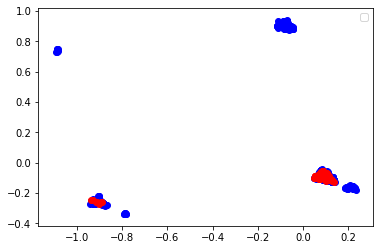

In [142]:
plt.scatter(xplot[0, k1], xplot[1, k1], color="b")
plt.scatter(xplot[0, k2], xplot[1, k2], color="r")
plt.legend()
plt.show()

## Train classifier using logistic regression model 

In [20]:
x_tr, y_tr = gram_data_tr
x_tr = x_tr.tocsr() # row format of sparse matrix, for row slicing
x_te, y_te = gram_data_te
x_te = x_te.tocsr()

In [143]:
clf = LogisticRegression(C=1, penalty="l2", solver="sag")


In [144]:
clf.fit(e.T, y_tr[:])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
# Save model
with open("logreg.mdpkl", "wb") as f:
    pickle.dump(clf, f)

In [37]:
# Load model
with open("logreg.mdpkl", "rb") as f:
    clf = pickle.load(f)

In [ ]:
clf = SVC(C=1.0, kernel="rbf")
clf.fit(x_tr, y_tr)

/Users/huo/.pyvenv/pgmpy/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Evaluation

In [38]:
print("Testing results.")
precision, recall, accuracy = evaluate(clf, x_te, y_te)
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)

Testing results.
tp, fp, tn, fn:  11108 829 5929 874
Precision:  0.9305520650079584
Recall:  0.9270572525454849
Accuracy:  0.9091248665955176


In [145]:
print("Training results.")
precision, recall, accuracy = evaluate(clf, e.T, y_tr)
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)

Training results.
tp, fp, tn, fn:  5431235 3169714 1 375235
Precision:  0.6314692715885188
Recall:  0.9353763990858474
Accuracy:  0.6050717537573034
